In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10

from ast import literal_eval
from sklearn.feature_extraction.text import CountVectorizer

data = pd.read_csv("../data/interim/trigrams3.csv")
data = data.drop(['Unnamed: 0'], axis=1)
data['TRIGRAMS'] = data['TRIGRAMS'].apply(literal_eval)
data.head()

,NUM,FACILITY,DATE,FINE,NARRATIVE,TRIGRAMS
0,20008964,FREMONT HEALTHCARE CENTER,2012-02-01,750.0,F323 483.25(h) FREE OF ACCIDENT HAZARDS/SUPERV...,"[hazard_supervision_device, device_prevent_acc..."
1,20009068,WILLOW TREE NURSING CENTER,2012-03-02,750.0,Title 22 72520 (a) If a patient of a skilled n...,"[skilled_nursing_facility, hospital_define_sec..."
2,20009069,KINDRED NURSING AND REHABILITATION - YGNACIO V...,2012-03-02,750.0,483.12(b) (3) Permitting Resident to Return to...,"[bed_hold_period, facility_immediately_availab..."
3,20009078,"BAY VIEW REHABILITATION HOSPITAL, LLC",2012-03-05,37500.0,483.25 PROVIDE CARE/SERVICES FOR HIGHEST WELL ...,"[service_high_beingeach, facility_provide_nece..."
4,20009082,LONE TREE CONVALESCENT HOSPITAL,2012-03-06,600.0,T22 DIV5 CH3 ART3-72311(a)(1)(A) Nursing Servi...,"[nursing_service_shall, include_limit_followin..."


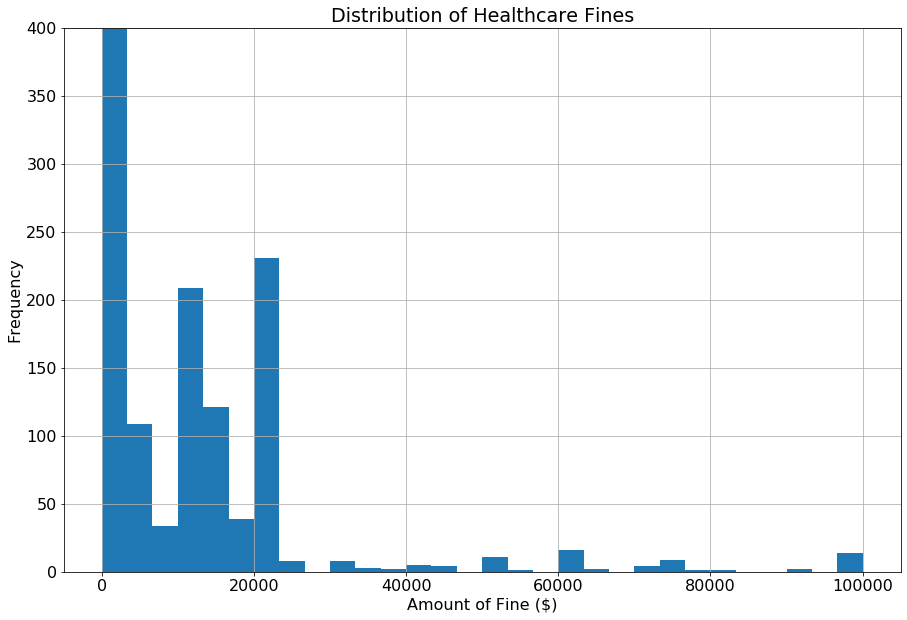

In [62]:
# In this histogram, the y-axis is capped at 400 to show finer detail.
# The first bar actually represents a freqeuency of about 2,000 records.

data['FINE'].hist(bins = 30)
plt.xlabel('Amount of Fine ($)')
plt.ylabel('Frequency')
plt.ylim([0, 400])
plt.title('Distribution of Healthcare Fines')
plt.rcParams.update({'font.size': 16})
plt.show()

In [63]:
data['FINE'].describe()

count      2883.000000
mean       6498.753382
std       12021.629895
min           0.000000
25%        1000.000000
50%        2000.000000
75%        7000.000000
max      100000.000000
Name: FINE, dtype: float64

In [64]:
# Build a corpus of strings out of the trigram column in the main database

corpus = [' '.join(data.loc[row, 'TRIGRAMS']) for row in range(len(data))] 
corpus[0][0:100], corpus[1][0:100], corpus[2][0:100]

('hazard_supervision_device device_prevent_accident facility_violate_regulation receive_adequate_super',
 'skilled_nursing_facility hospital_define_section skilled_nursing_facility patient_bedhold_seven faci',
 'bed_hold_period facility_immediately_availability resident-_require_service facility_ii_eligible fac')

In [65]:
# Convert the corpus to a vectorized bag of words

vectorizer = CountVectorizer(min_df=0)
vectorizer.fit(corpus)
x = vectorizer.transform(corpus)
x = x.toarray()
y = vectorizer.get_feature_names()

In [66]:
# Build a list of the most frequently appearing trigrams, not including trigrams that are
# merely a number, e.g. "20".

# Can set the generate value to 'False' to save time in constructing the frequency list, which is
# stored to disc.

generate = True

if generate:
    def generate_row(current_row_num, y):
        current_row = [(y[i], x[current_row_num][i]) for i in range(len(y))]
        return current_row

    freq = {} 

    for current_row_num in range(len(data)):
        for word in generate_row(current_row_num, y): 
            if (word[0] in freq): 
                freq[word[0]] += word[1]
            else: 
                freq[word[0]] = word[1]
            
    freq_df = pd.DataFrame.from_dict(freq, orient='index')
    freq_df.columns=['frequency']
    freq_df.index.name='word'
    freq_df.to_csv("../data/interim/wordfreqs.csv")

In [67]:
freq_df

,frequency
word,
00,2247
000,773
0000,2
000013,1
000030,4
...,...
ÿabout,1
ÿon,1
ÿthe,2


In [68]:
freq_df = pd.read_csv("../data/interim/wordfreqs.csv")
numbers = freq_df['word'].str.contains('^[0-9]*$')
top_words = freq_df[~numbers].sort_values('frequency', ascending=False).head(50)
top_words    

,word,frequency
66115,resident,93195
32597,facility,42661
74634,state,37519
57318,patient,31776
41798,indicate,24292
17762,care,18806
74185,staff,18395
24162,date,17792
66909,review,17593
19723,client,16772


In [69]:
bigrams = freq_df['word'].str.contains('_')
top_bigrams = freq_df[bigrams].sort_values('frequency', ascending=False).head(20)
top_bigrams   

,word,frequency
17819,care_plan,4508
59502,policy_procedure,3640
19871,clinical_record,2535
53755,note_date,2076
32840,fail_ensure,2059
26477,diagnosis_include,1999
61379,progress_note,1757
4373,30_p,1736
32680,facility_fail_ensure,1573
33189,family_member,1538


In [70]:
trigrams = [t for t in freq_df['word'] if t.count('_') == 2]
trigrams[0:5]

['000_colony_ml',
 '000_mg_daily',
 '000_unit_day',
 '0012861_serve_facility',
 '00_pm_11']

In [71]:
#freq_df['word'].in(trigrams)

In [72]:
trigrams = freq_df['word'].str.contains('^[^_]+_([^_]+)_[^_]+$')
top_trigrams = freq_df[trigrams].sort_values('frequency', ascending=False).head(20)
top_trigrams  

C:\Users\Jason GL\Anaconda3JGL\envs\biosphere\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,word,frequency
32680,facility_fail_ensure,1573
59513,policy_procedure_title,859
38278,health_safety_security,677
72419,skilled_nursing_facility,555
66935,review_clinical_record,555
8715,acute_care_hospital,532
61381,progress_note_date,509
46901,licensed_vocational_nurse,501
80888,unannounced_visit_facility,464
26248,device_prevent_accident,405


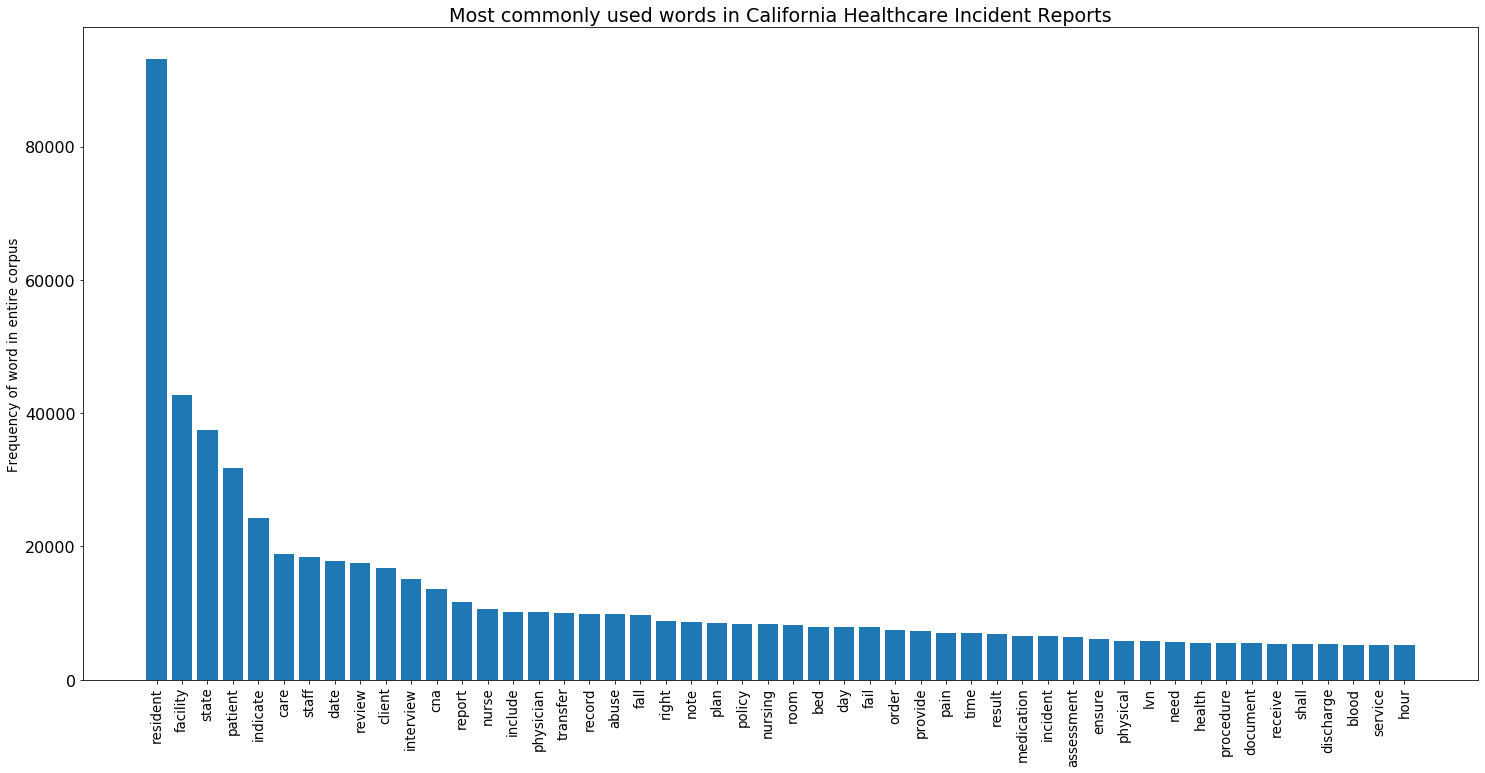

In [73]:
# Illustrate the most frequently appearing words

from pylab import rcParams
rcParams['figure.figsize'] = 25, 12

plt.bar(top_words['word'], top_words['frequency'])
plt.xticks(
    rotation=90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='small'  
)
plt.title('Most commonly used words in California Healthcare Incident Reports')
plt.ylabel('Frequency of word in entire corpus', fontsize='small')

fig1 = plt.gcf()
fig1.savefig('../reports/figures/wordfreqs.png')

plt.show()

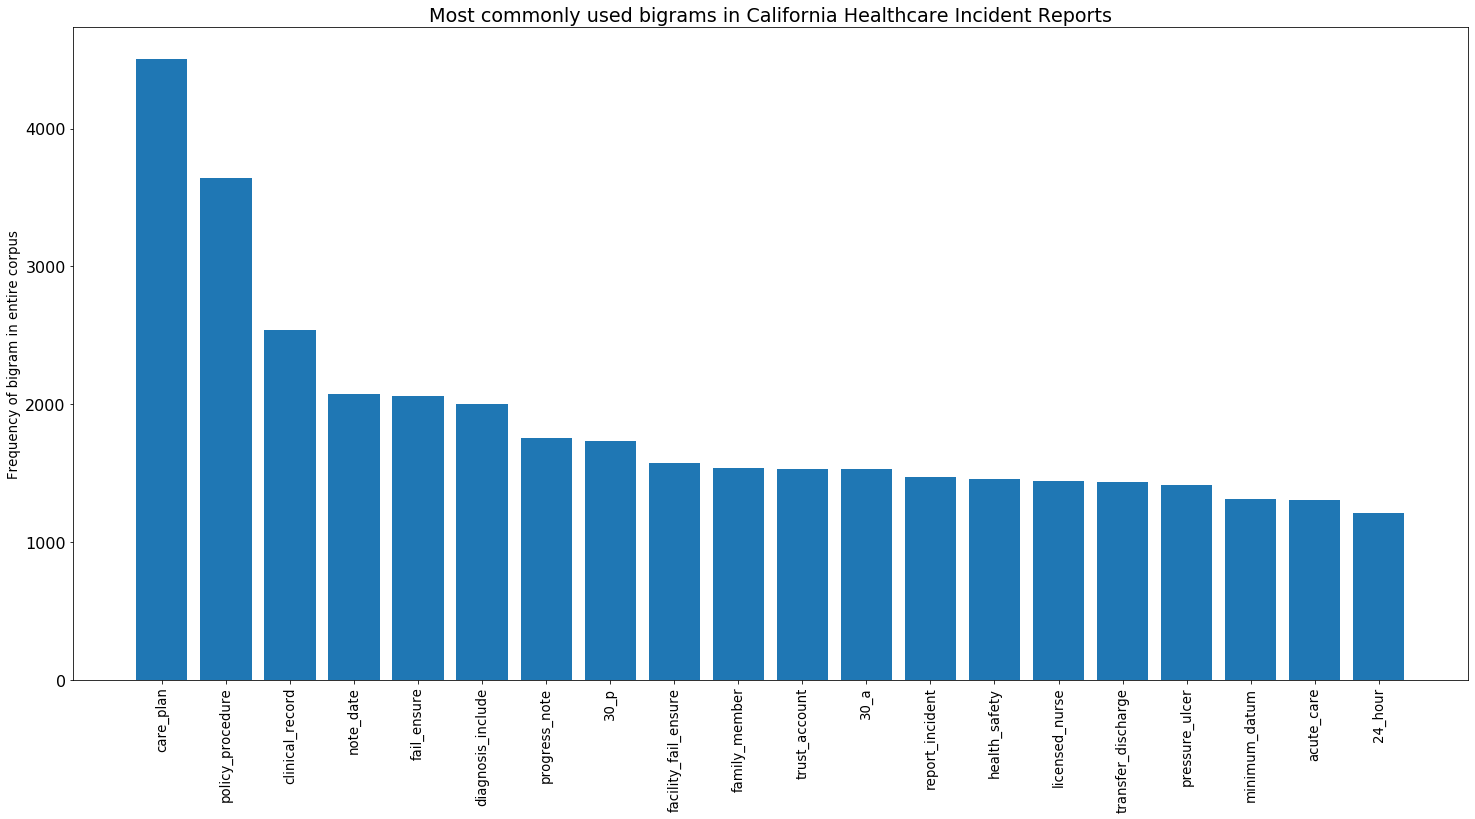

In [74]:
# Illustrate most common bigrams

plt.bar(top_bigrams['word'], top_bigrams['frequency'])
plt.xticks(
    rotation=90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='small'  
)
plt.title('Most commonly used bigrams in California Healthcare Incident Reports')
plt.ylabel('Frequency of bigram in entire corpus', fontsize='small')

fig1 = plt.gcf()
fig1.savefig('../reports/figures/bigramfreqs.png')

plt.show()

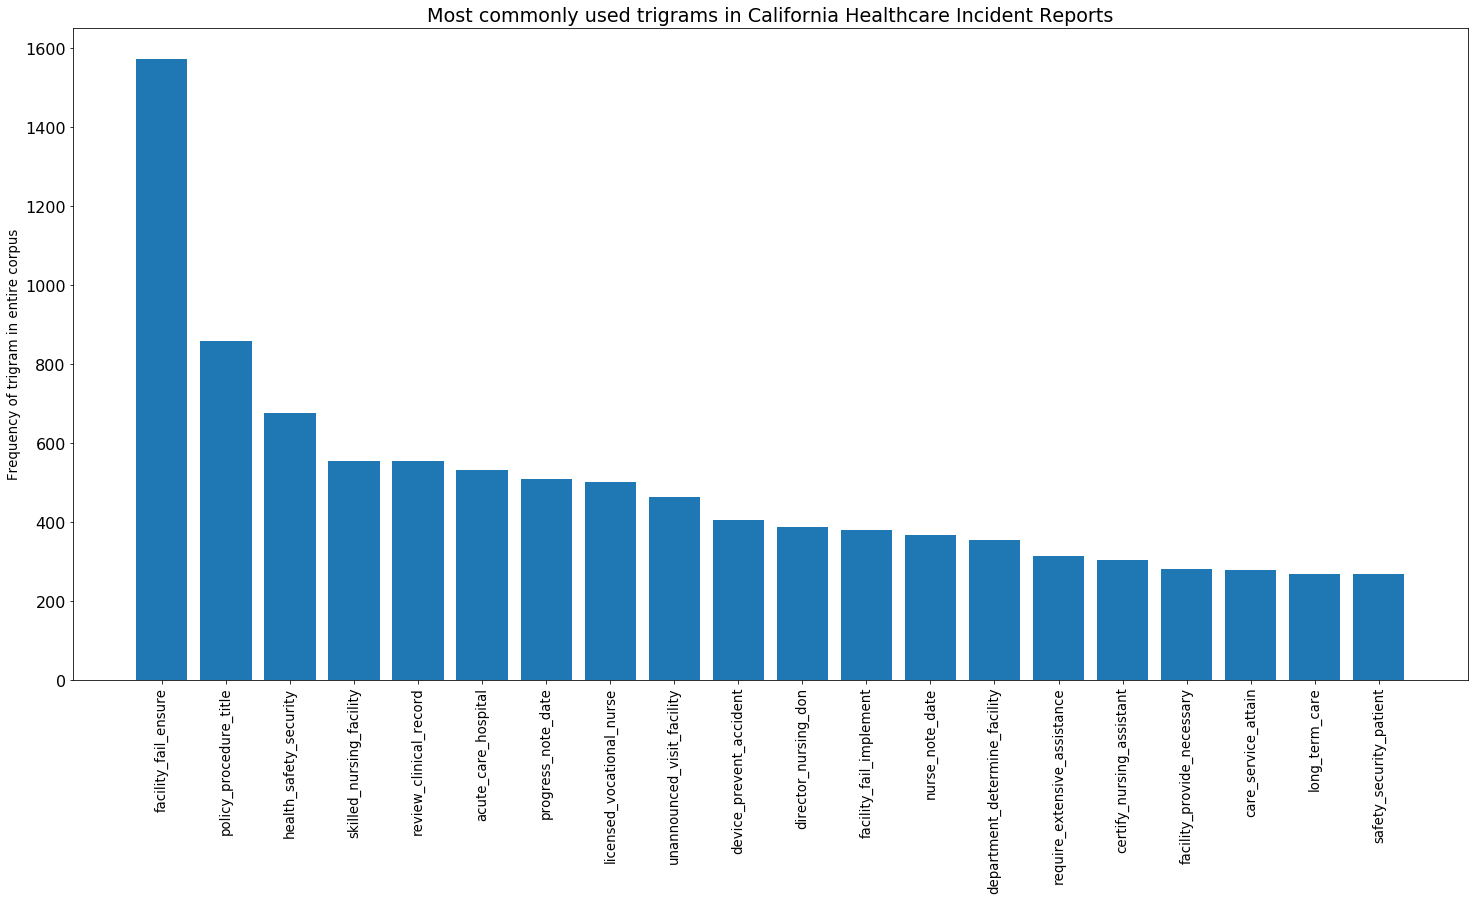

In [75]:
# Illustrate most common trigrams

plt.bar(top_trigrams['word'], top_trigrams['frequency'])
plt.xticks(
    rotation=90, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='small'  
)
plt.title('Most commonly used trigrams in California Healthcare Incident Reports')
plt.ylabel('Frequency of trigram in entire corpus', fontsize='small')

fig1 = plt.gcf()
fig1.savefig('../reports/figures/trigramfreqs.png')

plt.show()

In [76]:
# Break it up by fine amount

nofine = data[data['FINE'] == 0]
smallfine = data[(data['FINE'] > 0) & (data['FINE'] < 2000)]
medfine = data[(data['FINE'] >= 2000) & (data['FINE'] < 10000)]
largefine = data[data['FINE'] > 10000]

nofine.head()

,NUM,FACILITY,DATE,FINE,NARRATIVE,TRIGRAMS
35,20010062,WINDSOR ROSEWOOD CARE CENTER,2013-08-13,0.0,The facility failed to issue a proper written ...,"[issue_proper_write, write_contact_information..."
36,20010065,WINDSOR ROSEWOOD CARE CENTER,2013-08-13,0.0,?483.12(a)(4)(5)(6) NOTICE REQUIREMENTS BEFORE...,"[483.12(a)(4)(5)(6_notice_requirement, facilit..."
37,20010066,WINDSOR ROSEWOOD CARE CENTER,2013-08-13,0.0,?483.12(a)(4)(5)(6) NOTICE REQUIREMENTS BEFORE...,"[483.12(a)(4)(5)(6_notice_requirement, facilit..."
38,20010067,WINDSOR ROSEWOOD CARE CENTER,2013-08-13,0.0,?483.12(a)(4)(5)(6) NOTICE REQUIREMENTS BEFORE...,"[483.12(a)(4)(5)(6_notice_requirement, facilit..."
39,20010069,WINDSOR ROSEWOOD CARE CENTER,2013-08-13,0.0,?483.12(a)(4)(5)(6) NOTICE REQUIREMENTS BEFORE...,"[483.12(a)(4)(5)(6_notice_requirement, facilit..."


In [77]:
len(nofine), len(smallfine), len(medfine), len(largefine)

(24, 1007, 1161, 543)

In [78]:
# This step is very time-consuming, so I have saved the results to disk. Only set 'generateLists' to True if you want
# to re-generate each lsit instead of importing them from disk.

generateLists = False

if generateLists:

    no_fine_words = pd.Series()
    for row in range(len(nofine)):
        nextentry = pd.Series(nofine.iloc[row, 5]).value_counts()
        no_fine_words = no_fine_words.add(nextentry, fill_value=0)
    no_fine_words = no_fine_words[no_fine_words > 100] / len(nofine)
    no_fine_words = no_fine_words.sort_values()

    small_fine_words = pd.Series()
    for row in range(len(smallfine)):
        nextentry = pd.Series(smallfine.iloc[row, 5]).value_counts()
        small_fine_words = small_fine_words.add(nextentry, fill_value=0)
    small_fine_words = small_fine_words[small_fine_words > 100] / len(smallfine)
    small_fine_words = small_fine_words.sort_values()

    med_fine_words = pd.Series()
    for row in range(len(medfine)):
        nextentry = pd.Series(medfine.iloc[row, 5]).value_counts()
        med_fine_words = med_fine_words.add(nextentry, fill_value=0)
    med_fine_words = med_fine_words[med_fine_words > 100] / len(medfine)
    med_fine_words = med_fine_words.sort_values()

    large_fine_words = pd.Series()
    for row in range(len(largefine)):
        nextentry = pd.Series(largefine.iloc[row, 5]).value_counts()
        large_fine_words = large_fine_words.add(nextentry, fill_value=0)
    large_fine_words = large_fine_words[large_fine_words > 100] / len(largefine)
    large_fine_words = large_fine_words.sort_values()

    all_words = pd.Series()
    for row in range(len(data)):
        nextentry = pd.Series(data.iloc[row, 5]).value_counts()
        all_words = all_words.add(nextentry, fill_value=0)
    all_words = all_words[all_words > 100] / len(data)
    all_words = all_words * -1
    all_words = all_words.sort_values()

    no_fine_words.to_csv("../data/interim/nofine.csv")
    small_fine_words.to_csv("../data/interim/smallfine.csv")
    med_fine_words.to_csv("../data/interim/medfine.csv")
    large_fine_words.to_csv("../data/interim/largefine.csv")
    all_words.to_csv("../data/interim/allfine.csv")

In [79]:
# This function converts each saved spreadsheet into a series while dropping unnecessary information.
# The function is inelegant but seems needed now that pd.Series.from_csv has been deprecated.

def process_csv_series(filename):
    path = "../data/interim/" + filename
    temp = pd.read_csv(path, squeeze=True, header=None, index_col=False)
    temp.index = temp.loc[:, 0]
    temp.index.name = None
    output = temp.drop(0, axis=1)[1]
    return output

In [80]:
# Import each list of characteristic words from disk

no_fine_words = process_csv_series("nofine.csv")
small_fine_words = process_csv_series("smallfine.csv")
med_fine_words = process_csv_series("medfine.csv")
large_fine_words = process_csv_series("largefine.csv")
all_words = process_csv_series("allfine.csv")

In [81]:
no_fine_diff = no_fine_words.add(all_words, fill_value=0).sort_values(ascending=False).head(50)
no_fine_diff.head(10)

discharge             23.618583
notice                 9.249436
write                  5.982700
transfer_discharge     5.210935
record                 4.845907
facility               4.817508
reason                 4.773023
clinical               4.678937
clinical_record        4.247095
resident               3.940513
Name: 1, dtype: float64

In [82]:
small_fine_diff = small_fine_words.add(all_words, fill_value=0).sort_values(ascending=False).head(50)
small_fine_diff.head(10)

client           3.705954
account          1.273200
patient          1.107136
shall            0.991659
dcs              0.696888
ad               0.654802
o                0.646013
trust_account    0.573573
trust            0.559239
abuse            0.515419
Name: 1, dtype: float64

In [83]:
med_fine_diff = med_fine_words.add(all_words, fill_value=0).sort_values(ascending=False).head(50)
med_fine_diff.head(10)

facility              1.387168
abuse                 0.950418
transfer              0.860893
discharge             0.743368
administrator         0.523244
allegation            0.460354
transfer_discharge    0.392352
notice                0.382619
ssd                   0.372970
adm                   0.372497
Name: 1, dtype: float64

In [84]:
large_fine_diff = large_fine_words.add(all_words, fill_value=0).sort_values(ascending=False).head(50)
large_fine_diff.head(10)

resident     26.921176
1            14.936275
indicate      8.159690
's            7.002627
care          6.483262
fall          5.014626
date          4.459658
review        4.262869
state         4.169297
physician     3.911418
Name: 1, dtype: float64

In [85]:
all_words.head(10)

resident   -31.226153
1          -23.452307
facility   -13.807492
state      -13.003815
's         -12.619840
patient    -10.480749
indicate    -8.425945
2           -6.662851
care        -6.446757
staff       -6.271592
Name: 1, dtype: float64

In [86]:
top_words_by_fine_size = pd.DataFrame({"no_fine": no_fine_diff.index,
                  "small_fine":small_fine_diff.index,
                  "med_fine": med_fine_diff.index,
                  "large_fine": large_fine_diff.index})
top_words_by_fine_size.head(20)

,no_fine,small_fine,med_fine,large_fine
0,discharge,client,facility,resident
1,notice,account,abuse,1
2,write,patient,transfer,indicate
3,transfer_discharge,shall,discharge,'s
4,record,dcs,administrator,care
5,facility,ad,allegation,fall
6,reason,o,transfer_discharge,date
7,clinical,trust_account,notice,review
8,clinical_record,trust,ssd,state
9,resident,abuse,adm,physician
